imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
import gc


paths and globals definitions

In [2]:
"""run this if you are working from google colab!!"""
# from google.colab import drive
# drive.mount('/content/gdrive')
# code_dir = "/content/gdrive/MyDrive/neural network project"

'run this if you are working from google colab!!'

In [3]:
"""run this if you are working from your local computer!!"""
code_dir = os.getcwd()

In [4]:
############## TENSORBOARD ########################
writer = SummaryWriter("runs/PNEUMOTHORAX")
###################################################

data_dir = os.path.join(code_dir, "Data")
class_file_path = os.path.join(code_dir, "train_data.csv")

PNEUMOTHORAX = 1
NOT_PNEUMOTHORAX = 0
classes = {PNEUMOTHORAX, NOT_PNEUMOTHORAX}
num_classes = len(classes)

classification_file = pd.read_csv(class_file_path, header=0)

# Hyper-parameters
batch_size = 8
num_workers = 0
epochs = 2
learning_rate = 0.001


dataset definition

In [5]:
class PneumDataset(Dataset):
    def __init__(self, data_path, images_paths, labels, transform):
        # init custom dataset attributes
        self.data_path = data_path
        self.X_images = images_paths
        self.y_labels = labels
        self.transform = transform

    def __len__(self):
        # len of the dataset
        return len(self.X_images)

    def __getitem__(self, index):
        # get specific sample by index
        img_path = self.X_images[index]
        label = self.y_labels[index]

        # opening the image
        path = os.path.join(self.data_path, img_path)
        image = Image.open(path)
        image = image.convert("RGB")
        
        # converting x,y to tensors
        image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        label = label.view(1)
        return image, label

loading and splitting the data

In [6]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

images_paths = np.asarray(classification_file["file_name"])
images_targets = np.asarray(classification_file["target"])

# split to train and test
X_train, X_test, y_train, y_test = train_test_split(images_paths, images_targets, stratify=images_targets, random_state = 50)

# transform
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                                ])

# create dataloaders
train_dataset = PneumDataset(data_dir, X_train, y_train, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers)

test_dataset = PneumDataset(data_dir, X_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers)


Visualize a few images

One batch images shape: torch.Size([8, 3, 224, 224])
One batch labels shape: torch.Size([8, 1])
One iteration size: 190


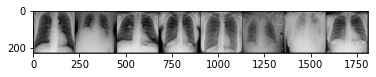

In [7]:
# get some random training images
dataiter = iter(train_loader)
example_images, example_labels = dataiter.next()  # random batch

# batch shapes
print(f'One batch images shape: {example_images.shape}')
print(f'One batch labels shape: {example_labels.shape}')
print(f'One iteration size: {len(dataiter)}')

# show images
img_grid = torchvision.utils.make_grid(example_images)
imshow(img_grid)

############## TENSORBOARD ########################
writer.add_image('PNEUMOTHORAX image grid', img_grid)
###################################################

cnn model definition

In [8]:
class PneumNet(nn.Module):
    def __init__(self):
        super(PneumNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=20)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=20)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features =16*41*41, out_features=100 )
        self.fc2 = nn.Linear(in_features=100, out_features = 50)
        self.fc3 = nn.Linear(in_features=50, out_features=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


checking the shape after each model step

In [9]:
x = PneumNet().relu(PneumNet().conv1(example_images))
print(x.shape)
x = PneumNet().pool1(x)
print(x.shape)
x = PneumNet().relu(PneumNet().conv2(x))
print(x.shape)
x = PneumNet().pool2(x)
print(x.shape)
x = x.view(x.size(0), -1)
print(x.shape)
x = torch.relu(PneumNet().fc1(x))
print(x.shape)
x = torch.relu(PneumNet().fc2(x))
print(x.shape)
x = PneumNet().fc3(x)
print(x.shape)


torch.Size([8, 6, 205, 205])
torch.Size([8, 6, 102, 102])
torch.Size([8, 16, 83, 83])
torch.Size([8, 16, 41, 41])
torch.Size([8, 26896])
torch.Size([8, 100])
torch.Size([8, 50])
torch.Size([8, 1])


transfer learning model definition

In [10]:
vgg_model = models.vgg16(pretrained=True)
# Freeze model weights
for param in vgg_model.parameters():
    param.requires_grad = False

n_inputs = vgg_model.classifier[6].in_features

vgg_model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 1))
print(vgg_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

loss, optimizer definition 

In [11]:
# device
device = "cpu"
if (torch.cuda.is_available()):
    gc.collect()
    torch.cuda.empty_cache()
    device = "cuda"
print(f"Working on device: {device}")

# model
model = PneumNet().to(device)
# model = vgg_model.to(device)

# loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # binary cross entropy
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ############## TENSORBOARD ########################
# writer.add_graph(model, example_images.to(device))
# ###################################################


Working on device: cuda


train function

In [12]:
def binary_acc(outputs, labels):
    predicted = torch.round(torch.sigmoid(outputs))
    correct_results_sum = (predicted == labels).sum().float()
    acc = correct_results_sum/outputs.shape[0]
    acc = torch.round(acc * 100)
    return acc

    
def train(data_loader, model, optimizer, device, epochs):    
    model.train()
    
    train_size = len(data_loader)
        
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for i, data in enumerate(data_loader):
            (images, labels) = data
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = binary_acc(outputs, labels)
            
            # Backward 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Loss and Accuracy Track
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        epoch_loss = epoch_loss/train_size
        epoch_acc = epoch_acc/train_size
        print(f'Epoch: {epoch}/{ epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # ############## TENSORBOARD ########################
        # writer.add_scalar('training loss', epoch_loss, epoch)
        # writer.add_scalar('accuracy', epoch_acc, epoch)
        # ###################################################


print("Begin training. \n")
train(train_loader, model, optimizer, device, epochs)


Begin training. 

Epoch: 0/1 Loss: 0.5716 Acc: 75.6526
Epoch: 1/1 Loss: 0.5238 Acc: 78.9368


test function

Accuracy of the network on the 507 test images: 78.69822485207101 %


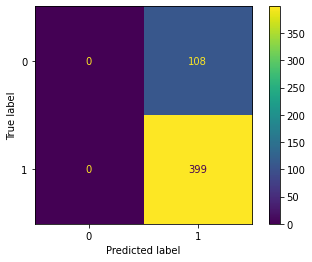

In [16]:
def one_dimantion_label(labels):
    labels = [np.squeeze(a).tolist() for a in labels]
    new_labels = []
    for batch in labels:
        for b in batch:
            new_labels.append(b)
    return new_labels
    
def test(data_loader, model, device):
    model.eval()
    
    # no_grad context
    with torch.no_grad():
        predicted_labels = []
        original_labels = []
        for data in data_loader:
            (images, labels) = data

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            # predict
            outputs = model(images)
            
            predicted = torch.round(torch.sigmoid(outputs))
            predicted_labels.append(predicted.cpu().numpy())
            original_labels.append(labels.cpu().numpy())

        original_labels = one_dimantion_label(original_labels)
        predicted_labels = one_dimantion_label(predicted_labels)
        
    return original_labels, predicted_labels


original_labels, predicted_labels = test(test_loader, model, device=device)

test_len = len(original_labels)
correct_results_sum = sum([1 for (p, o) in zip(predicted_labels, original_labels) if p == o])
total_acc = 100.0 * (correct_results_sum / test_len)
print(f'Accuracy of the network on the {test_len} test images: {total_acc} %')
    

cm = confusion_matrix(original_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

# ############## TENSORBOARD ########################
# for i in classes:
#     labels_i = class_labels == i
#     preds_i = class_preds[:, i]
#     writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
# writer.close()
# ###################################################
